In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

# Batch Identification Algorithm(Offline)

## Function definitions

In [2]:
def calculate_kernel_matrix(x,y,hyperparam,kernel_type):
    '''
    kernel_type:'linear' or 'gaussian' or 'polynomial'
    hyperparam: sigma for gaussian, degree for polynomial
    '''
    if kernel_type=='linear':
        K = np.outer(x,y)
    if kernel_type=='gaussian':
        K = np.exp(-0.5*((x[:,None]-y[None,:])**2)/(hyperparam**2))
    if kernel_type=='polynomial':
        K = (1+np.outer(x,y))**hyperparam
    return K

In [3]:
def find_ls_h(x,L,d,reg_param_channel):
    col1 = x
    row1 = np.zeros(L)
    X = toeplitz(col1,row1)
    
    h_opt = (np.linalg.inv(X.T@X+reg_param_channel*np.eye(L)))@(X.T@d)
    
    return h_opt

In [4]:
def find_kernel_coeff(K,h,Ks,d,reg_param_kernel):
    H = toeplitz(np.concatenate((h,np.zeros(len(K)-len(h)))),np.zeros(len(K)))
    K_h = H@K
    inv = np.linalg.inv(K_h.T@K_h+reg_param_kernel*Ks)
    b = K_h.T@d
    alpha = inv@b
    return alpha

In [5]:
def batch_identification_kiham(x,d,h_init,channel_dict,kernel_dict,convergence_dict):
    
    L = channel_dict['Length']
    reg_param_channel = channel_dict['Regularisation']
    
    M = kernel_dict['Support Number']
    spac = kernel_dict['Support Spacing']
    reg_param_kernel = kernel_dict['Regularisation']
    kernel_type = kernel_dict['Type']
    kernel_hyperparam = kernel_dict['Hyperparameter']
    
    max_iter = convergence_dict['Maximum Iterations']
    err_tol = convergence_dict['Error Tolerance']
    
    x_s = np.arange(-0.5*M,0.5*M,spac)
    
    K = calculate_kernel_matrix(x,x_s,kernel_hyperparam,kernel_type)
    Ks = calculate_kernel_matrix(x_s,x_s,kernel_hyperparam,kernel_type)
    
    d_norm = np.linalg.norm(d)
    
    # Initialise h[n]
    
    h = h_init/np.linalg.norm(h_init)
    h_linear = h.copy()
        
    n_iter = 0
    
    J_frac = d_norm**2
    
    while ((n_iter<=max_iter) and (J_frac>=err_tol)):
        alpha = find_kernel_coeff(K,h,Ks,d,reg_param_kernel)
        f_x = K@alpha
        h = find_ls_h(f_x,L,d,reg_param_channel)
        h = h/np.linalg.norm(h)
        
        H = toeplitz(np.concatenate((h,np.zeros(len(x)-len(h)))),np.zeros(len(x)))
                
        n_iter+=1
        J_frac = (np.linalg.norm(d-H@K@alpha))**2/np.linalg.norm(d)
    
    return h,alpha,n_iter,J_frac,x_s,h_linear

In [6]:
n_iter = 1024
x = np.random.randn(n_iter)
f_x = np.tanh(3*x)

h_actual = np.loadtxt(open("rir1.csv"), delimiter=",")

d = np.convolve(h_actual,f_x)[0:n_iter]+0.001*np.random.randn(n_iter)

M = 50
spac = 0.2
c_h = 1.0
c_a = 0.01
sigma = 0.4

L = 256
k_type = 'gaussian'

max_iter = 50
err_tol = 1e-4

channel_att = {'Length':L,'Regularisation':c_h}
kernel_att = {'Support Number':M,'Support Spacing':spac,
              'Regularisation':c_a,'Type':k_type,'Hyperparameter':sigma}
conv_att = {'Maximum Iterations':max_iter,'Error Tolerance':err_tol}

h_init = find_ls_h(x,L,d,c_h)

h,alpha,el_iter,J_frac,x_s,h_linear = batch_identification_kiham(x,d,h_init,channel_att,kernel_att,conv_att)

In [7]:
x_ = np.linspace(-3,3,101)
y = np.tanh(3*x_)

K_new = calculate_kernel_matrix(x_,x_s,sigma,'gaussian')

y_pred = K_new@alpha

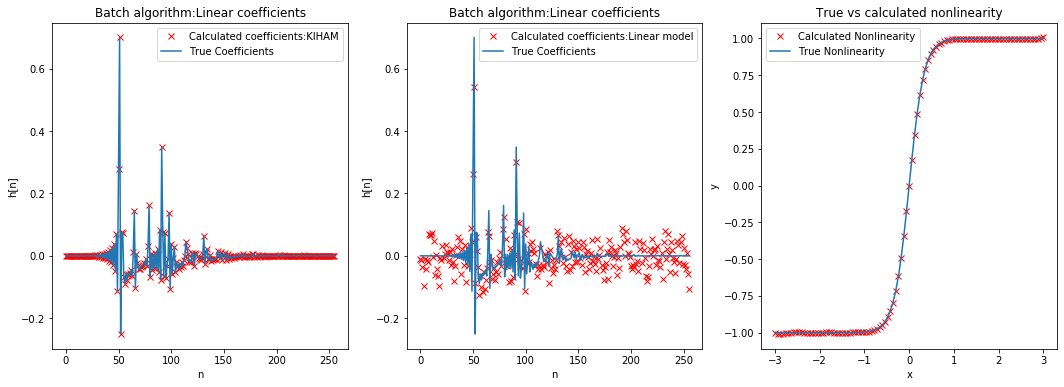

In [26]:
fig, ax = plt.subplots(1,3,figsize=(18,6))

ax[0].plot(h,'rx',label='Calculated coefficients:KIHAM')
ax[0].plot(h_actual,label='True Coefficients')
ax[0].set_xlabel('n')
ax[0].set_ylabel('h[n]')
ax[0].set_title('Batch algorithm:Linear coefficients')
ax[0].legend()

ax[1].plot(h_linear,'rx',label='Calculated coefficients:Linear model')
ax[1].plot(h_actual,label='True Coefficients')
ax[1].set_xlabel('n')
ax[1].set_ylabel('h[n]')
ax[1].set_title('Batch algorithm:Linear coefficients')
ax[1].legend()

ax[2].plot(x_,y_pred,'rx',label='Calculated Nonlinearity')
ax[2].plot(x_,y,label='True Nonlinearity')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_title('True vs calculated nonlinearity')
ax[2].legend()

#plt.savefig('batch.png')
plt.show()

In [9]:
J_frac

0.00014955080031167907

In [10]:
d_linear_pred = np.convolve(h_linear,x)[0:n_iter]
J_linear = np.linalg.norm(d-d_linear_pred)/np.linalg.norm(d)
J_linear

0.4803247339355206

# Online learning: Static nonlinearity and time varying channel

Uptil the input length fills a buffer of a predetermined length, one performs NLMS to obtain estimates for channel coefficients. Then one uses the data in the buffer to obtain estimates for kernel coefficients and channel coefficients. Then one continues updating the coefficients for the linear path by NLMS

In [17]:
Nb = [768,1024,2048]
n_iter = 16000
n_ensemble = 100

M = 50
spac = 0.2
c_h = 10.0
c_a = 0.01
sigma = 0.4

L = 256
k_type = 'gaussian'

x_s = np.arange(-0.5*M,0.5*M,spac)
Ks = calculate_kernel_matrix(x_s,x_s,sigma,'gaussian')

max_iter = 50
err_tol = 1e-4

channel_att = {'Length':L,'Regularisation':c_h}
kernel_att = {'Support Number':M,'Support Spacing':spac,
              'Regularisation':c_a,'Type':k_type,'Hyperparameter':sigma}
conv_att = {'Maximum Iterations':max_iter,'Error Tolerance':err_tol}

mu = 0.2

x_iter = np.zeros(L)
x_temp = np.zeros(L)
h_nlms = np.random.randn(L)
erle = np.zeros((3,n_ensemble,n_iter))
f_x_iter = np.zeros(L)


for k in range(3):
    for j in range(n_ensemble):
        x_iter = np.zeros(L)
        x_train = np.zeros(Nb[k])
        d_train = np.zeros(Nb[k])
        h_nlms = np.zeros(L)
        for i in range(Nb[k]):
            x_iter[1:] = x_iter[0:-1].copy()
            x_iter[0] = np.random.randn(1)
            x_train[i] = x_iter[0].copy()
            
            d_iter = np.tanh(x_iter)@h_actual+0.0001*np.random.randn(1)
            d_train[i] = d_iter.copy()
            
            pred_temp = np.sum(x_iter*h_nlms)
            err_temp = d_iter-pred_temp

            erle[k][j][i] = 10*np.log10(d_iter**2/err_temp**2)

            h_nlms_new = h_nlms+mu*(err_temp*x_iter-c_h*h_nlms)/(c_h+np.linalg.norm(x_iter**2))

            h_nlms = h_nlms_new.copy()

        h_nlms = h_nlms/np.linalg.norm(h_nlms)
        
        #h_init = find_ls_h(x_train,L,d_train,c_h)

        h_nlms,alpha,el_iter,J_frac,x_s,h_linear = batch_identification_kiham(x_train,d_train,h_nlms,channel_att,kernel_att,conv_att)
                
        f_x_iter = calculate_kernel_matrix(x_iter,x_s,sigma,'gaussian')@alpha
        f_x_temp = np.zeros(L)

        for i in range(Nb[k],n_iter):
            x_iter[1:] = x_iter[0:-1].copy()
            x_iter[0] = np.random.randn(1)
            
            d_iter = np.sum(np.tanh(x_iter)*h_actual)+0.0001*np.random.randn(1)

            f_x_new = calculate_kernel_matrix(np.array([x_iter[0]]),x_s,sigma,'gaussian')[0]@alpha
            
            f_x_iter[1:] = f_x_iter[0:-1].copy()
            f_x_iter[0] = f_x_new.copy()
            
            pred_temp = np.sum(f_x_iter*h_nlms)
            err_temp = d_iter-pred_temp

            erle[k][j][i] = 10*np.log10(d_iter**2/err_temp**2)

            h_nlms_new = h_nlms+mu*(err_temp*f_x_iter)/(c_h+np.linalg.norm(f_x_iter**2))

            h_nlms = h_nlms_new.copy()

In [18]:
erle = np.mean(erle,axis=1)

In [19]:
n_ensemble = 300
erle_linear = np.zeros((n_ensemble,n_iter))

for j in range(n_ensemble):
    x_iter = np.zeros(L)
    h_nlms = np.zeros(L)
    for i in range(n_iter):
        x_iter[1:] = x_iter[0:-1].copy()
        x_iter[0] = np.random.randn(1)

        d_iter = np.sum(np.tanh(x_iter)*h_actual)+0.0001*np.random.randn(1)
        
        pred_temp = np.sum(x_iter*h_nlms)
        err_temp = d_iter-pred_temp

        erle_linear[j][i] = 10*np.log10(d_iter**2/err_temp**2)

        h_nlms_new = h_nlms+mu*(err_temp*x_iter)/(c_h+np.linalg.norm(x_iter**2))

        h_nlms = h_nlms_new.copy()

In [20]:
erle_linear = np.mean(erle_linear,axis=0)

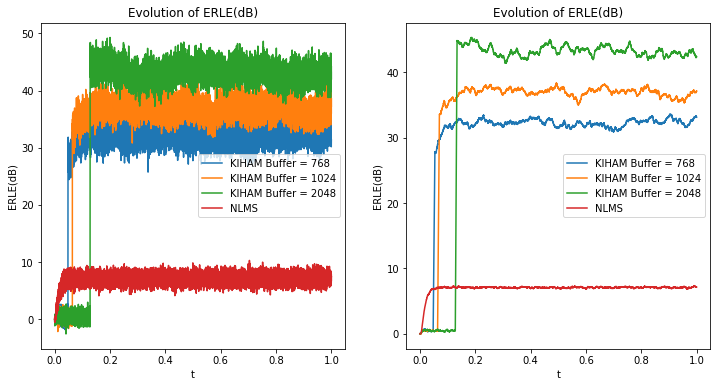

In [27]:
t = np.linspace(0,1,n_iter)

mva = 0.01*np.ones(100)
b1 = np.convolve(erle[0],mva)[0:len(t)]
b2 = np.convolve(erle[1],mva)[0:len(t)]
b3 = np.convolve(erle[2],mva)[0:len(t)]
b4 = np.convolve(erle_linear,mva)[0:len(t)]

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(t,erle[0],label='KIHAM Buffer = 768')
ax[0].plot(t,erle[1],label='KIHAM Buffer = 1024')
ax[0].plot(t,erle[2],label='KIHAM Buffer = 2048')
ax[0].plot(t,erle_linear,label='NLMS')
ax[0].set_xlabel('t')
ax[0].set_ylabel('ERLE(dB)')
ax[0].set_title('Evolution of ERLE(dB)')
ax[0].legend()

ax[1].plot(t,b1,label='KIHAM Buffer = 768')
ax[1].plot(t,b2,label='KIHAM Buffer = 1024')
ax[1].plot(t,b3,label='KIHAM Buffer = 2048')
ax[1].plot(t,b4,label='NLMS')
ax[1].set_xlabel('t')
ax[1].set_ylabel('ERLE(dB)')
ax[1].set_title('Evolution of ERLE(dB)')
ax[1].legend()

#plt.savefig('fig2.png')

plt.show()

# Online learning: Time varying nonlinearity and channel, LMS like algorithm and NLMS-like algorithm (Extra)

**This part is extra work on my behalf as an extension of the work done in the paper and the concepts covered in class.**

Here we update coefficients for both the kernel and the linear part in real time. Since the cost is a least squares one, the gradient and update are of the same form as any standard quadratic cost minimisation, but with more complexities due to presence of two parts to optimise over. Here since we are dealing with real vectors, we use transpose instead of conjugate

We write the full mathematical form for the cost again below:

$J = ||d-h * K\alpha||^2+c_{\alpha}\alpha^T K_s \alpha +c_hh^Th$

Writing the gradients:

$(\nabla_{\alpha}J)^T = (K_h^T K_h + c_{\alpha}K_s)\alpha -K_h^Td$

$(\nabla_{h}J)^T = (K_{\alpha}^T K_{\alpha} + c_{h}I)h -K_{\alpha}^Td$

The actual variable to estimate is h and $\alpha$ stacked. The gradient wrt this variable is just the gradients of each stacked. **Finding the Hessian however is no trivial task**

The hessian is given by:

$\nabla^2 J = \begin{pmatrix}\nabla^2_{\alpha} J&S\\S^T&\nabla^2_{\alpha} J\end{pmatrix}$

Finding the matrix S, which corresponds to cross-terms, is not trivial. **However while Newton's method requires inverse of Hessian times gradient transpose as descent direction, using any other positive semidefinite matrix will also be a valid descent direction, though the cost will not decrease as quickly as Newton's method. We note that the matrix**

$A = \begin{pmatrix}\nabla^2_{\alpha} J&0\\0&\nabla^2_{\alpha}J \end{pmatrix}^{-1} = \begin{pmatrix}(\nabla^2_{\alpha} J)^{-1}&0\\0&(\nabla^2_{\alpha}J)^{-1}\end{pmatrix}$

$(\nabla^2_{\alpha} J) = (K_h^T K_h + c_{\alpha}K_s),(\nabla^2_{h} J) = (K_{\alpha}^T K_{\alpha} + c_{h}I)$

**is also positive definite. So assuming this we derive NLMS-like expressions for update. The true NLMS update equations would have made use of the correct Hessian expressions, but we use a different positive definite matrix which give us expressions that look like NLMS updates in each of h and $\alpha$ individually**

Also, because we have added a regularisation parameter, the update equations are similar to leaky-LMS/leaky NLMS as discussed in the textbook by Sayed.

LMS-like update equation:

$h_{i+1} = h_i +\mu (K_{\alpha_i}^T[d_i-K_{\alpha_i}h_i]-c_h h_i)$

$\alpha_{i+1} = \alpha_i +\mu(K_{h_i}^T[d_i-K_{h_i}\alpha_i]-c_{\alpha} \alpha_i)$

Here both $K_{\alpha_i}^T$ and $K_{h_i}^T$ are column vectors, not matrices, since we are only dealing with one data point at a time.

NLMS like update equation:

$h_{i+1} = h_i +\mu \frac{(K_{\alpha_i}^T[d_i-K_{\alpha_i}h_i]-c_h h_i)}{c_h+K_{\alpha_i} K_{\alpha_i}^T}$

$\alpha_{i+1} = \alpha_i +\frac{\mu}{c_\alpha}(K_s^{-1})(I-\frac{K_{h_i}^T K_{h_i} K_s^{-1}}{c_\alpha+K_{h_i}K_s^{-1}K_{h_i}^T})(K_{h_i}^T[d_i-K_{h_i}\alpha_i]-c_{\alpha} \alpha_i)$

In [22]:
Nb = [2048]
n_iter = 16000
n_ensemble = 100

M = 50
spac = 0.2
c_h = 10.0
c_a = 0.1
sigma = 0.4

L = 256
k_type = 'gaussian'

x_s = np.arange(-0.5*M,0.5*M,spac)
Ks = calculate_kernel_matrix(x_s,x_s,sigma,'gaussian')

max_iter = 50
err_tol = 1e-4

channel_att = {'Length':L,'Regularisation':c_h}
kernel_att = {'Support Number':M,'Support Spacing':spac,
              'Regularisation':c_a,'Type':k_type,'Hyperparameter':sigma}
conv_att = {'Maximum Iterations':max_iter,'Error Tolerance':err_tol}

mu = 0.02

x_iter = np.zeros(L)
x_temp = np.zeros(L)
h_nlms = np.random.randn(L)
erle_new = np.zeros((3,n_ensemble,n_iter))
f_x_iter = np.zeros(L)


for k in range(1):
    for j in range(n_ensemble):
        x_iter = np.zeros(L)
        x_train = np.zeros(Nb[k])
        d_train = np.zeros(Nb[k])
        h_nlms = np.zeros(L)
        del alpha
        for i in range(Nb[k]):
            x_iter[1:] = x_iter[0:-1].copy()
            x_iter[0] = np.random.randn(1)
            x_train[i] = x_iter[0].copy()
            
            d_iter = np.tanh(x_iter)@h_actual+0.0001*np.random.randn(1)
            d_train[i] = d_iter.copy()
            
            pred_temp = np.sum(x_iter*h_nlms)
            err_temp = d_iter-pred_temp

            erle_new[k][j][i] = 10*np.log10(d_iter**2/err_temp**2)

            h_nlms_new = h_nlms+mu*(err_temp*x_iter-c_h*h_nlms)/(c_h+np.linalg.norm(x_iter**2))

            h_nlms = h_nlms_new.copy()

        h_nlms = h_nlms/np.linalg.norm(h_nlms)
        
        #h_init = find_ls_h(x_train,L,d_train,c_h)

        h_nlms,alpha,el_iter,J_frac,x_s,h_linear = batch_identification_kiham(x_train,d_train,h_nlms,channel_att,kernel_att,conv_att)
        #print(J_frac)
        
        f_x_iter = calculate_kernel_matrix(x_iter,x_s,sigma,'gaussian')@alpha
        f_x_temp = np.zeros(L)

        for i in range(Nb[k],n_iter):
            x_iter[1:] = x_iter[0:-1].copy()
            x_iter[0] = np.random.randn(1)
            
            d_iter = np.sum(np.tanh(x_iter)*h_actual)+0.0001*np.random.randn(1)

            f_x_new = calculate_kernel_matrix(np.array([x_iter[0]]),x_s,sigma,'gaussian')[0]@alpha
            
            f_x_iter[1:] = f_x_iter[0:-1].copy()
            f_x_iter[0] = f_x_new.copy()
            
            pred_temp = np.sum(f_x_iter*h_nlms)
            err_temp = d_iter-pred_temp

            erle_new[k][j][i] = 10*np.log10(d_iter**2/err_temp**2)
            
            Khi = h_nlms[0]*calculate_kernel_matrix(np.array([x_iter[0]]),x_s,sigma,'gaussian')[0]
        
            #temp = np.eye(len(Ks))-(np.outer(Khi,Khi)@Ks_inv)/(c_a+Khi@(Ks_inv@Khi))
        
            alpha_new = alpha+mu*((d_iter-Khi@alpha)*Khi)
            
            h_nlms_new = h_nlms+mu*(err_temp*f_x_iter)/(c_h+np.linalg.norm(f_x_iter**2))
            
            h_nlms = h_nlms_new.copy()
            
            alpha = alpha_new.copy()

In [23]:
erle_new = np.mean(erle_new,axis=1)
erle_old = erle[-1]

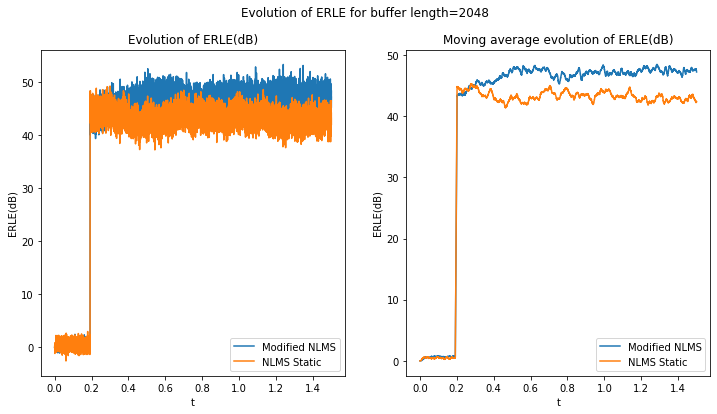

In [28]:
t = np.linspace(0,1.5,n_iter)
#plt.plot(t,erle_lms_new,label='Modified LMS')
fig, ax = plt.subplots(1,2,figsize=(12,6))

mva = 0.01*np.ones(100)
a1 = np.convolve(mva,erle_new[0])[0:len(t)]
a2 = np.convolve(mva,erle_old)[0:len(t)]

ax[0].plot(t,erle_new[0],label='Modified NLMS')
ax[0].plot(t,erle_old,label='NLMS Static')
ax[0].set_xlabel('t')
ax[0].set_ylabel('ERLE(dB)')
ax[0].set_title('Evolution of ERLE(dB)')
ax[0].legend()

ax[1].plot(t,a1,label='Modified NLMS')
ax[1].plot(t,a2,label='NLMS Static')
ax[1].set_xlabel('t')
ax[1].set_ylabel('ERLE(dB)')
ax[1].set_title('Moving average evolution of ERLE(dB)')
ax[1].legend()

plt.suptitle('Evolution of ERLE for buffer length=2048')
#plt.savefig('fig3.png')
plt.show()

#plt.savefig('fig3.png')